In [65]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import iglob
from math import sqrt
from scipy.io import wavfile
from utils import read_wav
from scipy.signal import spectrogram
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from itertools import zip_longest
from IPython.core.display import HTML

from keras.layers import LSTM, Dense, Convolution1D
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed, Bidirectional

from scipy.signal import resample

%matplotlib inline

Using TensorFlow backend.


In [21]:
HTML(r"""
<style>
    .custom-table img {padding: 40px !important;}
    .custom-table center {
        font-weight: 300;
        line-height: 1;
        letter-spacing: -0.3px;
        font-size: 20px;
    }
</style>
""")

## О задаче

<img src="img/asr.png" width="700"/>


**Automatic Speech Recognition (ASR)** -- задача по преобразованию звуковых данных (файлов на диске, звукового потока по сети, etc) с речью человека в текст. Задача осложняется тем, что на звуковой дорожке может присутствовать шум, музыка, говорящих может быть несколько человек, они могут перебивать друг друга. По объему вычислений и сложности задача сопоставима с распознаванием образов на изображениях.

Ранее для решения задачи распознавания речи использовались [Hidden Markov Model](https://en.wikipedia.org/wiki/Hidden_Markov_model) и [Gaussian Mixture Model](https://en.wikipedia.org/wiki/Mixture_model#Multivariate_Gaussian_mixture_model), но с развитием GPU вычислений и после прихода нейросетей, сначала в распознавание изображений, а затем и в другие области, стали использовать их.

## Нейросети

Разговор про нейросети принятно начинать с упоминания перцептрона Розенблатта, в некотором смысле копирующего биологический нейрон.

### Биологическая модель нейрона

<img src="img/neuron.png" width="600"/>

### Perceptron, Rosenblatt, 1957

<img src="img/perceptron.png" width="600"/>

Перцептрон имеет на входе некоторое количество сигналов $x_0, x_1, \ldots, x_{n-1}$ (в примере на картинке $n=3$) и $n+1$ обучаемых параметров, также называемых "весами" $w_0, w_1, \ldots, w_{n-1}$ и смещением $b$. Перцептрон выдает взвешенную сумму входов с весами с аддитивной поправкой смещения $b$, пропущенной через нелинейную монотонно возрастающую функцию активации $f$.

Если обозначить $x = (x_0, x_1, \ldots, x_{n-1}), w = (w_0, w_1, \ldots w_{n-1})$, то перцептрон считает следующую функцию 

$$y(x) = f\Big(\sum_i w_i x_i + b\Big) = f(\langle w, x \rangle + b)$$

Из этой формулы видно, что перцептрон выдает тем сильнее сигнал, чем сильнее входной вектор $x$ похож на вектор весов $w$. Можно сказать, что перцептрон подходит для детектирования определенного паттерна во входном векторе.


### Функции активации

![](img/activation_functions.png)


Функции активации должны быть дифференцируемы. Это нужно для последующего обучения нейросети градиентными методами. Кроме того, для ускорения вычислений желательно, чтобы значение производной являлось функцией от входа и посчитанного значения функции на этом входе. На рисунке выше представлены три функции активации (в порядке от верхней к нижней):

* Sigmoid, сигмоида
* tanh
* ReLU (Rectifier linear unit)

Сигмоида и tanh полезны, когда значения выхода нейрона должны быть ограничены ($(0, 1)$ и $(-1, 1)$ соответственно). ReLU полезна, когда значения на выходе нейрона должны быть положительны.


### Feedforward сети

![](img/feedforward.png)

Перцептроны обединяют в слои, а слои -- в сети. В данном примере нейросеть принимает на вход три действительных числа: $x_1$ -- площадь комнаты, $x_2$ -- расстояние до центра, $x_3$ -- количество комнат, и предсказывает стоимость аренды квартиры $y$ с данными параметрами. Поскольку все, что делает перцептрон -- это скалярное умножение, покомпонентное сложение и применение функции активации, удобно все вычисления проводить в матричной форме. $W^{(1)}, W^{(2)}, W^{(3)}, b^{(1)}, b^{(2)}, b^{(3)}$ -- параметры нейросети. $i$-тая строка в матрице весов $W^{(j)}$ соответствует вектору весов для $i$-того нейрона в $j$-том слое. $b_i^{(j)}$ -- его смещение.

Из примера выше понятно, зачем функции активации быть нелинейной -- в противном случае вся сеть заменяется на одну линейную функцию от входа.

В произвольном случае нейросеть -- это некоторый computational graph от входа с дифференцируемыми операциями в вершинах.

### Обучение нейросети

Пусть есть набор данных $\mathcal{D} = \{(x^{(1)}, y^{(1)}), \ldots, (x^{(l)}, y^{(l)})\}$, где $x$ -- вход для нейросети, $y$ -- ответ. Фиксируем некоторую архитектуру нейросети, то есть фиксируем некоторый граф вычислений со входом $x$, выходом $y$ и параметрами $\Theta$, $y = G(x, \Theta)$ -- результат работы этого графа на входе $x$. Мы хотим научиться по проивзольному $x$ предсказывать $y$, то есть аппроксимировать некоторую функцию $y = g(x)$ по точкам из $\mathcal{D}$. Мы говорим, что наша оценка $\hat{y}(x; \Theta)$ -- это реультат работы графа вычислений с параметрами $\Theta$ на входе $x$, то есть $G(x; \Theta)$. Для подбора наилучших параметров вводится функционал

$$\mathcal{L}(\Theta) = \sum_{i=1}^{n} Loss(\hat{y}(x^{(i)}, \Theta); y^{(i)})$$

, где Loss – некая дифференцируемая функция потерь, мала, когда $\hat{y}(x^{(i)}, \Theta) \approx y^{(i)}$, велика, когда $\hat{y}(x^{(i)}, \Theta) \not \approx y^{(i)}$, в примере про стоимость аренды подходит $Loss(a, b) = (a-b)^2$

Далее, оптимальный параметры находятся путем минимизации данного функционала

$$\hat{\Theta} = \text{argmin}_{\Theta} \mathcal{L}(\Theta)$$

Для минимизации используеют градиентный спуск 

$$\Theta_{n+1} = \Theta_n - \alpha \frac{\partial L}{\partial \Theta}(\Theta_n)$$

, где $\alpha$ -- learning rate (скорость обучения). Начальное приближение обычно берут около нуля, но есть и другие техники инициализации:

$$\Theta_1 \sim \mathcal{N}(0, 0.01 \cdot I_n)$$

$$\frac{\partial L}{\partial \Theta} = \sum_{i=1}^{l} \frac{\partial Loss(\hat{y}(x^{(i)}, \Theta); y^{(i)})}{\partial \hat{y}(x^{(i)}, \Theta)} \cdot \frac{\partial \hat{y}(x^{(i)}, \Theta)}{\partial \Theta}$$

$l ≈ 10^6 – 10^7$, поэтому считать сумму из $l$ элементов на каждом шаге проблематично. Решение: stochastic gradient descent (SGD).

Выбираем случайно из $\mathcal{D}$ k объектов $\{(x_{batch}^{(i)}, y_{batch}^{(i)}) : i = 1..k\} \subset \mathcal{D}$

$$\frac{\partial L}{\partial \Theta} \approx \sum_{i=1}^{k} \frac{\partial Loss(\hat{y}(x_{batch}^{(i)}, \Theta); y_{batch}^{(i)})}{\partial \hat{y}(x_{batch}^{(i)}, \Theta)} \cdot \frac{\partial \hat{y}(x_{batch}^{(i)}, \Theta)}{\partial \Theta}$$

<table class="custom-table">
<tr style="background:white">
<td style="width:50%">
![](img/gd.png)
<center>Иллюстрация градиентного спуска</center>
</td>
<td>
![](img/learning_rate_selection_2.png)
<center>О выборе learning rate</center>
</td>
</tr>
<tr style="background:white">
<td style="width:50%">
![](img/learning_rate_selection_1.png)
<center>О выборе learning rate</center>
</td>
<td>
![](img/real_loss_function.png)
<center>График функции потерь от номера итерации</center>
</td>
</tr>
</table>

### References

* [Why are deep neural networks hard to train?](http://neuralnetworksanddeeplearning.com/chap5.html)
* [An overview of gradient descent optimization algorithms](http://sebastianruder.com/optimizing-gradient-descent/)
* [Why momentum really works](http://distill.pub/2017/momentum/) 
* [cs231n Learning](http://cs231n.github.io/neural-networks-3/)

## Tensorflow

Это конечно, круто, но как использовать на практике?

Существует много фреймворков для обучения нейросетей. Мы будем использовать Tensorflow и Keras. Tensorflow предоставляет low-level (по сравнению с Keras) Python API для построения и запуска произвольных графов вычислений. Keras же предоставляет высокоуровневый интерфейс для создания многослойных архитектур нейросетевых моделей. Keras может использовать Tensorflow либо Theano в качестве бекэнда. В данном ноутбуке мы будем использовать Tensorflow backend для Keras.

Решим модельную задачу:

$$\min_y (y-4)^2$$

Понятно, что решение -- это $y=4$. Научимся на основе этой задачи задавать и заускать computational графы в Tensorflow.

Сначала определяем граф вычислений:

In [182]:
# Создаем новый граф
g = tf.Graph()

# Используем его для всех операций внутри конекста как граф по умолчанию
with g.as_default():
    # опеределяем переменную (параметры модели), которую будем подбирать, с начальным значением 0.
    # Tensorflow переменные и константы это не то же самое, что Python переменные, это операции в графе вычислений.
    y = tf.Variable(initial_value=0, dtype=tf.float32)
    print("y:\n{}\n".format(y))
    
    # y_0 -- просто Tensorflow constant со значением 4
    y_0 = tf.constant(4, dtype=tf.float32)
    print("y_0:\n{}\n".format(y_0))
    
    # Опередляем функцию потерь, которую будем минимизировать
    # Это всего лишь определение функции, а не непосредственные вычисления.
    # Такое поведение достигается за счет переопределения __add__, __sub__, __pow__ у tf.Tensor
    loss = (y - y_0) ** 2
    print("loss:\n{}\n".format(loss))
    
    # Определяем операцию шага минимизации loss с learning_rate=1e-2 с помощью GradientDescentOptimizer
    optimizer_step = tf.train.GradientDescentOptimizer(learning_rate=1e-2).minimize(loss)
    print("optimizer_step:\n{}{}".format(optimizer_step, type(optimizer_step)))

y:
<tf.Variable 'Variable:0' shape=() dtype=float32_ref>

y_0:
Tensor("Const:0", shape=(), dtype=float32)

loss:
Tensor("pow:0", shape=(), dtype=float32)

optimizer_step:
name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_Variable/ApplyGradientDescent"
<class 'tensorflow.python.framework.ops.Operation'>


Теперь запускаем его

In [187]:
y_history = []
loss_history = []

def log_and_print(log_list, value):
    log_list.append(value)
    print(log_list[-1])

# Создаем новую сессию, в которой будет запускаться граф
with tf.Session(graph=g) as sess:
    # Инициализируем переменные
    sess.run(tf.global_variables_initializer())
    
    # Запускаем вычисление loss и y
    log_and_print(y_history, sess.run(y))
    loss_history.append(sess.run(loss))
    
    # Запускаем один шаг градиентного спуска
    sess.run(optimizer_step)
    
    # Проверяем, что loss уменьшился, а y стал ближе к истинному значению
    log_and_print(y_history, sess.run(y))
    loss_history.append(sess.run(loss))
    
    # Запускаем еще 200 шагов градиентного спуска, сохраняя попутно loss и y
    for i in range(200):
        sess.run(optimizer_step)
        y_history.append(sess.run(y))
        loss_history.append(sess.run(loss))
    
    print(y_history[-1])

0.0
0.08
3.93106


Как видим, y приближается к истинному значению 4, а loss уменьшается

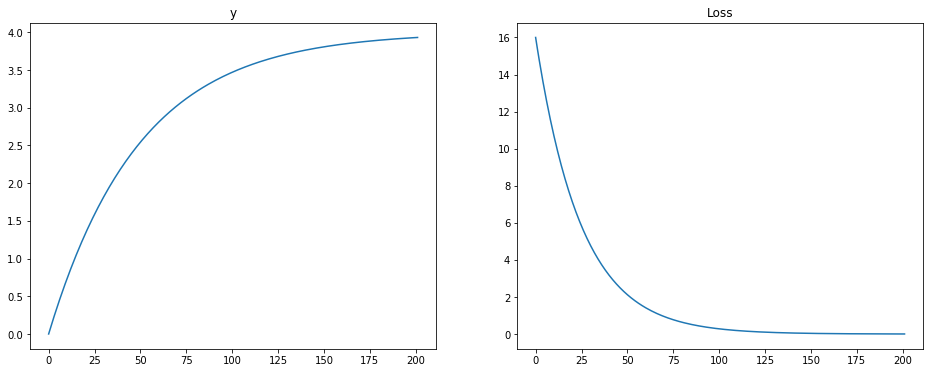

In [62]:
_, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(y_history)
axes[0].set_title("y")
axes[1].plot(loss_history)
axes[1].set_title("Loss")
plt.show()

## Keras

Для задания глубоких моделей со сложными слоями лучше пользоваться Keras. Когда Keras использует Tensorflow backend, функции и классы  из Keras можно смешивать с функциями и классами Tensorflow. Теоретически можно использовать чистый Tensorflow для задания всей модели, но практически так никто не делает. В крайнем случае, если не хочется дополнительных зависимостей, можно использовать [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers)

Решим следующую задачу: попробуем приблизить функцию $y=sin(x)$ 5-слойной нейронной сетью в некоторой окресности нуля.

In [203]:
g = tf.Graph()
with g.as_default():
    # Определяем два "плейсхолдера", в них можно будет подать рантайм значение на этапе запуска модели
    # через feed_dict параметр метода run у tf.Session
    x = tf.placeholder(tf.float32, shape=(None, 1))
    print(x)
    y = tf.placeholder(tf.float32, shape=(None, 1))
    print(y)

    # Оперделяем Keras модель Sequential, это простая последовательность слоев.
    model = Sequential()
    # Добавляем в модель 5 полносвязных слоев
    model.add(Dense(6, activation='relu', input_shape=(1,)))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='relu'))
    # Активация на последнем слое tanh, т.к. sin(x) \in [-1, 1]
    model.add(Dense(1, activation='tanh'))

    # Результат применения модели ко входу x
    y_hat = model(x)

    # Определеяем функцию потерь и шаг градиентного спуска. Здесь используем AdamOptimizer, это разновидность градиентного спуска.
    loss = tf.reduce_mean((y - y_hat) ** 2)
    optimizer_step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)

Tensor("Placeholder:0", shape=(?, 1), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


Тренироваться будем на парах $(x, \sin(x))$, где $x \sim \mathcal{N}(0, 1)$

In [228]:
loss_history = []

sess = tf.InteractiveSession(graph=g)
sess.run(tf.global_variables_initializer())

for i in range(3000):
    # Генерируем новый батч обучающей выборки
    x_batch = np.random.normal(scale=2.0, size=(32, 1))
    y_batch = np.sin(x_batch)
    
    # Запускаем оптимизатор, передаем x_batch и y_batch через feed_dict
    loss_batch, _ = sess.run([loss, optimizer_step], feed_dict={x: x_batch, y: y_batch})
    loss_history.append(loss_batch)

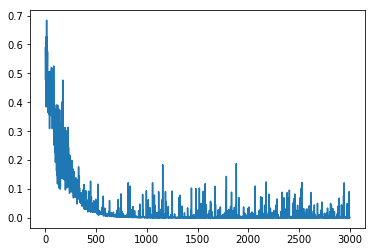

In [229]:
plt.plot(loss_history)

Протестируем сеть на входах $\frac{\pi}{2}, \frac{\pi}{4}, 0, -\frac{\pi}{4}, -\frac{\pi}{2}$

In [235]:
x_batch = np.array([np.pi/2, np.pi/4, 0, -np.pi/4, -np.pi/2]).reshape(5, -1)
y_batch_predict = sess.run(y_hat, feed_dict={x: x_batch})
print(y_batch_predict)

[[ 0.95871043]
 [ 0.69421232]
 [-0.00432443]
 [-0.6917578 ]
 [-0.9542892 ]]


In [236]:
y_batch = np.sin(x_batch)
print(y_batch)

[[ 1.        ]
 [ 0.70710678]
 [ 0.        ]
 [-0.70710678]
 [-1.        ]]


Как видим, сеть выдает довольно близкие к реальным значения

In [237]:
print(np.mean((y_batch_predict - y_batch) ** 2))

0.000842973005897


График аппроксимирующей функции близок в окресности нуля к графику синуса

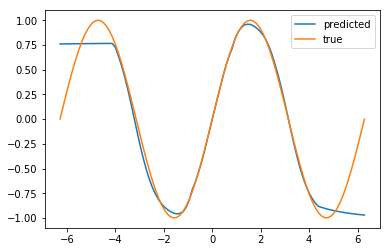

In [243]:
x_batch = np.linspace(-2*np.pi, 2*np.pi, 100).reshape(100, -1)
y_batch_predict = sess.run(y_hat, feed_dict={x: x_batch})
plt.plot(x_batch, y_batch_predict, label="predicted")
plt.plot(x_batch, np.sin(x_batch), label="true")
plt.legend()

## Рекуррентные нейросети

<img src="img/imagenet.png" width="500"/>

Выше -- пример классификации изображений с помощью [сверточных нейросетей](http://cs231n.github.io/convolutional-networks/) (СNN). Длина полосы под картинкой обозначает уверенность нейросети в том или ином классе. Как видно, CNN сеть хорошо справляется с классификацией стастических изобрежений.

Но что делать, когда есть временная размерность, которая может сильно повлиять на ответ? Например, если классифицировать нужно действия, совершаемые на каждом кадре видео, как в примере ниже. Интуитивно понятно, что есть корреляция между действиями на соседних кадрах, ведь действия начинаются и заканчиваются плавно. Кроме того, некоторый действия можно классифицировать только если иметь несоклько последовательных кадров (то есть когда последовательность и продолжительность элементарных движений важна).

<img src="img/frame_sequence.png" width="600"/>

Сети, имеющие в своей архитектуре рекуррентные соединения (от прошлого шага к текущему), называются рекуррентными. Их можно рассматривать как и обычные ациклические графы вычислений, если рекуррентность "развернуть" по времени. Кроме того, о состоянии, передающимся с помощью рекуррентного содеинения, можно думать как о ячейке памяти, в которую рекуррентная сеть может писать или читать.

<img src="img/vanilla_rnn_unroll.png" width=700/>

В примере выше задана однослойная однонаправленная рекуррентная сеть, считывающая последовательнсть $x_0, \ldots x_t$ и выдающая последовательность векторов (своего скрытого состояния) $h_0, \ldots h_t$. Сверху можно расположить еще один полносвязный слой, чтобы по $h_t$ получать $y_t$. В зависимости от того, как работает блок A, выделяют несколько архитектур рекуррентных нейросетей.

### Vanilla RNN

Самый простой тип рекуррентных нейросетей.


<img src="img/vanilla_rnn.png" width=700/>

$h_t$ и $y_t$ рассчитывается по формулам выше

#### Проблема длинных зависимостей


<img src="img/long_range_1.png" width=500/>

Рекуррентные сети в целом оказываются очень полезным инструментом для работы с последовательностями. Они способны запоминать информацию на некоторые промежутки времени, и потом делать предсказания, основанные на это информации. На картинке выше нейросеть предсказывает значение $h_3$, на основе $x_0$ и $x_1$. Такая зависимость называется короткой (short-term dependency), посколько нейросети достаточно запомнить информацию на шаге 0 и 1 лишь на несколько тактов вперед, чтобы сделать выводы на шаге с индексом 3.


<img src="img/long_range_2.png" width=600/>

Наоборот, на этой картинке при достаточно большом t (скажем, 100 или 200), нейросети придется "тащить" информацию на протежении большого количества тактов в своем скрытом состоянии. Оказывается, Vanilla RNN обладают такими свойствами, которые не позволяют им выучить матрицу перехода $W_hh$ для хранения таких длинных зависимостей. Об этой проблеме подробно написал Yoshua Bengio в [своей работе](http://www-dsi.ing.unifi.it/~paolo/ps/tnn-94-gradient.pdf) в 1994 году.

### LSTM -- Long Short-Term Memory

<img src="img/lstm.png" width=700/>
<img src="img/lstm_legend.png" width=400/>

Для борьбы с проблемами длинных зависимостей была придумана другая архитектура рекуррентных ячеек, назвыаемая LSTM. Общее строение ячеек LSTM представлено на рисунке выше. Основное отличие от Vanilla RNN -- в LSTM есть специальная дополнительная "ячейка памяти" $C_t$, которая со временем претерпевает всего два изменения -- поэлементное сложение и умножение. Поэлементность этих операций позволяет градиентному спуску эффективно выучивать длинные зависимости.

<img src="img/lstm_memory_cell.png" width=700/>

Кроме ячейки памяти LSTM содержит три "затвора" -- input gate $i_t$, forget gate $f_t$, output gate $o_t$.

<img src="img/lstm_forget_gate.png" width=700/>

Forget gate $f_t$ показывает, какую информацию ячейке нужно "забыть" на текущем шаге ($C_{t-1}$ домножаетяся на него поэлементно). Из-за использования сигмоидальной активации получаются значения как раз в интервале $(0, 1)$. 1 означает, что значение нужно оставить, 0 -- что забыть.

<img src="img/lstm_input_gate.png" width=700/>

Input gate $i_t$ производит алалогичные операции для вычисления доли информации, которая должна попасть в ячейку $C_t$. $\tilde{C_t}$ -- новое значение ячейки -- поэлементно домнажается на $i_t$ и результат прибавляется в $C_{t-1}$.

<img src="img/lstm_update_gate.png" width=700/>

Наконец, output gate $o_t$ обновляет $h_t$ по $h_{t-1}$ и $C_{t-1}$.

<img src="img/lstm_output_gate.png" width=700/>

### GRU -- Gated Recurrent Unit

<img src="img/gru.png" width=700/>

Модицикация LSTM, где вместо отдельного input gate используется $i_t = 1 - f_t$.

### Пример: моделирование языка

<img src="img/lm_1.png" width=400/>

Интересный [пример](http://karpathy.github.io/2015/05/21/rnn-effectiveness) применения рекуррентных сетей для генерации текста. Код на C ниже сгенерирован одной лишь нейросетью, обученной предсказываеть следующий символ текстовой последовательности на основе исходного кода ядра Linux.

<img src="img/lm_2.png" width=700/>

### RNN reference

* [cs224d course syllabus](http://cs224d.stanford.edu/syllabus.html)
* [cs224d video lectures](https://www.youtube.com/playlist?list=PLlJy-eBtNFt4CSVWYqscHDdP58M3zFHIG)
* [The Unreasonable Effectiveness of Recurrent Neural Networks, Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* [Understanding LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

## Работа с аудиоданными

## Архитектура нейросети для распознавания речи

## Тренируем нейросеть

In [11]:
lexicon = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine"
}

vocabulary = {chr(ord("a") + i): i for i in range(26)}
vocabulary[" "] = len(vocabulary)
inv_vocabulary = dict(zip(vocabulary.values(), vocabulary.keys()))

In [12]:
X = []
y = []
for filename in iglob("data/*.wav"):
    digits = map(int, os.path.basename(filename).split("__")[0].split("_"))
    data = read_wav(filename)
    X.append(extract_feats(data).T)
    y.append(list(map(lambda x: vocabulary[x], " ".join(map(lambda x: lexicon[x], digits)))))

n = len(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

'seven eight'

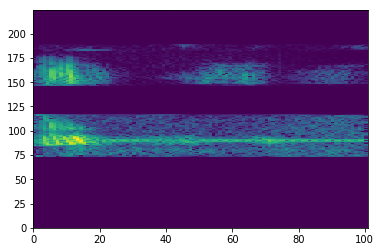

In [14]:
idx = 1
plt.pcolor(X_train[idx])
"".join(map(lambda x: inv_vocabulary[x], y_train[idx]))

In [18]:
g = tf.Graph()
with g.as_default():
    input_X = tf.placeholder(tf.float32, shape=[None, None, 101])
    labels = tf.sparse_placeholder(tf.int32)
    seq_lens = tf.placeholder(tf.int32, shape=[None])


    model = Sequential()
    model.add(Convolution1D(64, 5, padding='same', input_shape=(None, 101)))
    model.add(Convolution1D(64, 5, strides=2, padding='same'))
    model.add(Convolution1D(128, 5, padding='same'))
    model.add(Convolution1D(128, 5, strides=2, padding='same'))
    model.add(Bidirectional(LSTM(128, return_sequences=True, implementation=2)))
    model.add(TimeDistributed(Dense(len(vocabulary) + 1)))
    
    final_seq_lens = tf.cast(tf.ceil(tf.cast(tf.ceil(seq_lens / 2), tf.int32) / 2), tf.int32)

    logits = model(input_X)
    print(logits)
    logits = tf.transpose(logits, [1, 0, 2])

    ctc_loss = tf.reduce_mean(tf.nn.ctc_loss(labels, logits, final_seq_lens))
    # ctc_greedy_decoder? merge_repeated=True
    (decoded, ), _ = tf.nn.ctc_greedy_decoder(logits, final_seq_lens)
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded, tf.int32), labels))

    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(ctc_loss)

Tensor("sequential_1/time_distributed_1/Reshape_1:0", shape=(?, ?, 28), dtype=float32)


In [19]:
sess = tf.InteractiveSession(graph=g)

In [21]:
sess.run(tf.global_variables_initializer())
for epoch in range(1000):
    for X_batch, seq_lens_batch, y_batch, y_batch_orig in batch(X_train, y_train, 64):
        feed_dict = {
            input_X: X_batch,
            labels: y_batch,
            seq_lens: seq_lens_batch
        }
        train_loss, train_ler, train_decoded, true, _ = sess.run([ctc_loss, ler, decoded, labels, train_op], feed_dict=feed_dict)
    for X_batch, seq_lens_batch, y_batch, y_batch_orig in batch(X_test, y_test, 64):
        feed_dict = {
            input_X: X_batch,
            labels: y_batch,
            seq_lens: seq_lens_batch
        }
        test_loss, test_ler, test_decoded, true = sess.run([ctc_loss, ler, decoded, labels], feed_dict=feed_dict)
    print(f"{epoch}", train_loss, train_ler, decode(train_decoded, inv_vocabulary)[:10],  test_loss, test_ler)

0 25.9691 1.0 ['', '', '', '', '', '', '', '', '', ''] 25.8702 1.0
1 25.1709 1.0 ['', '', '', '', '', '', '', '', '', ''] 24.4147 1.0
2 25.4605 1.0 ['', '', '', '', '', '', '', '', '', ''] 27.7781 1.0
3 21.8964 1.0 ['', '', '', '', '', '', '', '', '', ''] 24.4684 1.0
4 25.5411 1.0 ['', '', '', '', '', '', '', '', '', ''] 26.0054 1.0
5 27.3518 1.0 ['', '', '', '', '', '', '', '', '', ''] 25.6213 1.0
6 23.519 0.971584 ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f'] 25.4287 0.968241
7 21.9425 0.948049 ['t', 't', 't', 't', 't', 't', 't', 't', 't', 't'] 23.4073 0.940685
8 22.3008 0.901432 ['fe', 'fe', 'fe', 'f', 'fe', 'f', 'f', 'fe', 'fe', 'fe'] 26.3196 0.882563
9 23.7424 0.854202 ['te', 'te', 'te', 'te', 'te', 'te', 'te', 'te', 'te', 'te'] 24.258 0.837414
10 21.3676 0.841927 ['te', 'te', 'te', 'te', 'te', 'te', 'te', 'te', 'te', 'te'] 24.8711 0.854045
11 22.8359 0.915853 ['te', 't', 't', 't', 't', 't', 't', 't', 'te', 't'] 23.1624 0.840567
12 23.3829 0.878296 ['se', 'se', 'se', 'se', 's

81 21.7721 0.794979 ['sine', 'fe', 'sine', 'sie', 'sie', 'tie', 'sine', 'fe', 'fe', 'fe'] 22.1452 0.793394
82 22.2597 0.7957 ['tine', 'tie', 'tine', 'tie', 'fe', 'tie', 'tine', 'tie', 'tie', 'fe'] 20.6444 0.818329
83 20.0878 0.794301 ['sie', 'sine', 'sine', 'sie', 'sie', 'sie', 'sie', 'sie', 'sie', 'sie'] 21.0014 0.806186
84 19.8422 0.81512 ['fie', 'si', 'sie', 'fi', 'fie', 'sie', 'fie', 'fi', 'sie', 'sie'] 21.7345 0.801602
85 23.6335 0.813331 ['fine', 'fie', 'fie', 'fie', 'fie', 'fie', 'fie', 'fie', 'fie', 'fie'] 21.5725 0.803146
86 21.6107 0.837396 ['fie', 'si', 'fi', 'tie', 'tie', 'fi', 'sine', 'fie', 'tie', 'tie'] 20.9285 0.793597
87 21.5916 0.806213 ['fine', 'fie', 'fine', 'fie', 'fie', 'fie', 'fi', 'fie', 'fie', 'fie'] 24.4083 0.802279
88 19.4532 0.773226 ['tie', 'tie', 'tie', 'tie', 'tie', 'tie', 'fie', 'fie', 'tie', 'sie'] 23.2244 0.809644
89 19.9542 0.828472 ['sie', 'si', 'si', 'sie', 'sie', 'sine', 'sie', 'sie', 'sie', 'sie'] 22.4438 0.819208
90 20.3346 0.760722 ['fie', 'fie'

151 12.1028 0.460958 ['five fie', 'fine', 'siuh', 'fine firo', 'fiur four eigh', 'sive', 'sigh', 'tire fine eix', 'finro five e', 'sien'] 12.7865 0.460242
152 13.0472 0.493493 ['fine tio fine', 'five firo five', 'fiur gh', 'firo eine ei', 'fiur ie x', 'five fivine', 'tio', 'five five eive', 'fiur tr', 'tiro exe fino'] 10.7245 0.397619
153 10.6465 0.479542 ['tiro', 'siven tie tii', 'tio sigh', 'tieo fine', 'tio fine tiro', 'five ene to', 'sine', 'siven', 'six', 'ti ix igh'] 10.9974 0.43379
154 11.2536 0.435025 ['tire', 'fiur tiro fine', 'siven', 'tiro eiro', 'fine', 'tie', 'tine', 'fine ire', 'tiro', 'fiur fiur'] 11.2266 0.477759
155 10.7215 0.439957 ['fight ur', 'fine fivr eive', 'fiue firo', 'tio tiro', 'fiur', 'fix fivo five', 'fine', 'fiur fiue', 'fiur fine', 'sine'] 12.1684 0.414638
156 11.5662 0.422847 ['tiro sigh', 'tio fine', 'five ive', 'fine ine tir', 'fivx eino ero', 'five fivh ine', 'sive igh', 'tw', 'tir eive ive', 'tiro ti'] 10.2165 0.387001
157 11.2555 0.418031 ['sivx eiv

202 5.86183 0.171609 ['four four', 'tero sixe sight', 'six sght', 'the ight', 'six', 'fix four siven', 'tho five', 'sight', 'sight sight', 'three sirx siven'] 4.82653 0.155013
203 5.75735 0.161239 ['five siven', 'three six', 'zero twree', 'four fegxt one', 'two four five', 'si five', 'tho sine', 'tero zero nine', 'six zero', 'siven'] 5.91684 0.175391
204 5.15741 0.162682 ['four sight', 'sight six', 'fone siven', 'the siven', 'sight', 'three eine six', 'fove foive siven', 'six', 'thro nine', 'zero'] 5.68808 0.167546
205 4.97907 0.161862 ['four four', 'twro fone sx', 'two one', 'six', 'four', 'four four foxr', 'sive six', 'fove one', 'one', 'two'] 5.73441 0.182976
206 4.83962 0.138403 ['fiur eight', 'four', 'fone', 'sine tho siven', 'six', 'five', 'six', 'zeree four', 'sive sine thee', 'fone zero nine'] 4.91608 0.157189
207 5.7572 0.184666 ['oine eight', 'siven fight ve', 'four fove', 'six fix four', 'fone sive', 'fine', 'nine', 'sive', 'twee', 'six zero nine'] 5.03299 0.178572
208 4.315

252 1.50071 0.0289652 ['zero five six', 'eight to', 'zero', 'zero zeo seven', 'four six zero', 'one eight', 'nine', 'seven zero', 'two one three', 'eight seven two'] 1.59102 0.0443159
253 1.03925 0.0113033 ['nine three', 'zero three eight', 'nine seven three', 'tho three eight', 'nine four five', 'one nine', 'nine', 'sive nine eight', 'four eight', 'nine'] 1.49917 0.0384401
254 1.23077 0.0129562 ['seven nine five', 'three eight', 'eight eeight seven', 'five', 'two', 'nine zero six', 'seven one zero', 'seven two eight', 'nine', 'two'] 1.65482 0.0297788
255 1.08484 0.0083494 ['five one', 'zero three', 'eight six', 'eight eght', 'nine', 'seven seven', 'five one nine', 'two', 'eight', 'two'] 1.40561 0.0334597
256 1.30361 0.0242906 ['six five', 'fight five seven', 'eight zero zero', 'one', 'eight two', 'three three', 'eight', 'zero', 'nine six', 'three four four'] 1.24168 0.0182468
257 1.08946 0.0126335 ['tho three', 'seven nine', 'eight seven four', 'four', 'zero three', 'seven', 'eight si

KeyboardInterrupt: 

In [40]:
with g.as_default():
    (decoded_beam, ), _ = tf.nn.ctc_beam_search_decoder(logits, final_seq_lens)

In [34]:
Audio("data/5_3_0__157a29673500e843c71d196a5a95585f.wav")

In [43]:
feats = extract_feats(read_wav("my_three.wav")).T

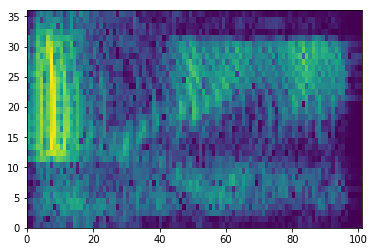

In [44]:
plt.pcolor(feats)

In [45]:
test_decoded = sess.run(decoded_beam, feed_dict={input_X: feats.reshape((1, -1, 101)), seq_lens: [len(feats)]})

In [46]:
decode(test_decoded, inv_vocabulary)

['t']

## Тестируем нейросеть

## Заключение

## Ссылки